#Setup

## Import dependencies

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

## Load data

In [3]:
#Load Disney stock data
df =pd.read_csv("DIS.csv")

In [4]:
#Show the data
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,37.970001,38.459999,37.939999,38.310001,34.300625,9704200
1,2012-01-04,38.189999,38.990002,38.119999,38.849998,34.784107,9889900
2,2012-01-05,38.830002,39.580002,38.700001,39.500000,35.366077,14327100
3,2012-01-06,39.549999,40.150002,39.450001,39.910000,35.733166,14401600
4,2012-01-09,39.740002,40.250000,39.590000,39.750000,35.589912,12145200
...,...,...,...,...,...,...,...
2721,2022-10-25,102.160004,104.730003,102.029999,104.360001,104.360001,7687500
2722,2022-10-26,103.529999,107.430000,103.529999,104.629997,104.629997,9203700
2723,2022-10-27,105.809998,106.870003,104.309998,104.440002,104.440002,8673500
2724,2022-10-28,104.080002,106.089996,103.529999,105.949997,105.949997,7250900


# Preprocess the data

## Use date as index

In [5]:
df = df.set_index('Date')

## Reorder columns

In [6]:
df=df[['High','Low','Open','Close','Volume','Adj Close']]

In [7]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,38.459999,37.939999,37.970001,38.310001,9704200,34.300625
2012-01-04,38.990002,38.119999,38.189999,38.849998,9889900,34.784107
2012-01-05,39.580002,38.700001,38.830002,39.500000,14327100,35.366077
2012-01-06,40.150002,39.450001,39.549999,39.910000,14401600,35.733166
2012-01-09,40.250000,39.590000,39.740002,39.750000,12145200,35.589912
...,...,...,...,...,...,...
2022-10-25,104.730003,102.029999,102.160004,104.360001,7687500,104.360001
2022-10-26,107.430000,103.529999,103.529999,104.629997,9203700,104.629997
2022-10-27,106.870003,104.309998,105.809998,104.440002,8673500,104.440002


## Check for null values

In [8]:
df.isnull().any()

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

## Get number of rows and columns in data set

In [9]:
df.shape

(2726, 6)

## Visualise closing price history

Text(0, 0.5, 'Close Price USD ($)')

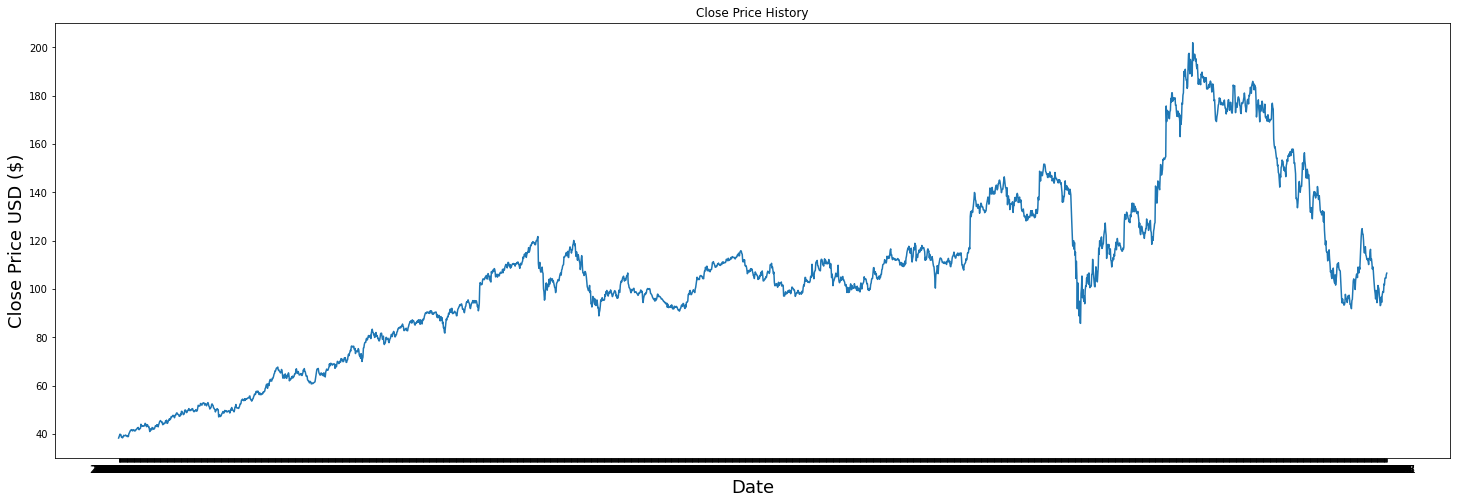

In [10]:
plt.figure(figsize=(25,8))
plt.title('Close Price History')
plt.plot(df.index,df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

## Create new dataframe with only close column and convert to numpy array

In [11]:
data = df.filter(['Close'])

#Convert dataframe to numpy array
dataset = data.values

## Scale the data

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.00330072],
       [0.00727383],
       ...,
       [0.4042176 ],
       [0.4134474 ],
       [0.41705378]])

#Define functions

## Create training dataset

In [13]:
def createTrainingDataset(days,training_data_len) :

  #Create training data set
  train_data = scaled_data[0:training_data_len,:]

  #Split data into x_train and y_train
  x_train = []
  y_train = []

  for i in range(days, len(train_data)):
    x_train.append(train_data[i-days:i,0])
    y_train.append(train_data[i,0])

  #Convert x_train and y_train to numpy arrays
  x_train, y_train = np.array(x_train), np.array(y_train)

  #Reshape the training dataset
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
  print(f"x_train shape : {x_train.shape}")

  return [x_train,y_train]

## Create test dataset

In [14]:
def createTestDataset(days,training_data_len):
  #Create a new array containing scaled values from index 1543 to 2002
  test_data = scaled_data[training_data_len - days: , :]

  #Create the data sets x_test and y_test
  x_test = []
  y_test = dataset[training_data_len:,:]

  for i in range(days,len(test_data)):
    x_test.append(test_data[i-days:i,0])

  #Convert x_test to numpy arrays
  x_test = np.array(x_test)

  #Reshape the test dataset
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

  return [x_test,y_test]

## Build and Train Model

In [15]:
def buildAndTrainModel(batch_size,epochs,x_train,y_train):
  #Define Model
  model = Sequential()
  model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(50,return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  #Compile the model
  model.compile(optimizer='adam',loss='mean_squared_error') #Optimizer used to improve upon loss function and loss function is to measure model performance

  #Train the model
  print("Training Model :")
  model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs)

  return model

##Make Predictions

In [16]:
def makePredictions(model,x_test,y_test):
  #Get model predicted price values
  scaled_predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(scaled_predictions)

  #Get model root mean squared error (RMSE)
  rmse = np.sqrt(np.mean(predictions - y_test)**2)
  print(f"RMSE : {rmse}")

  return predictions

## Plot the data

In [48]:
def plotData(training_data_len, predictions):
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid['Predictions'] = predictions

  #Visualise predictions vs actual
  plt.figure(figsize=(16,8))
  plt.title('Model')
  plt.xlabel('Date',fontsize=18)
  plt.ylabel('Closing Price USD ($)', fontsize=18)
  plt.plot(valid[['Close','Predictions']])
  plt.legend(['Val','Predictions'], loc='lower right')
  plt.show()

  #Show list of actual and predicted prices
  print(f"Actual and predicted prices")
  print(valid)
  return valid




## Calculate Model Accuracy

In [46]:
def calculateAccuracy(valid):
  valid_list = valid.values.tolist()

  accuracy = []
  total_accuracy = 0

  for result in valid_list :
    accuracy.append(abs(result[1] - result[0])/result[0])
  
  total_accuracy = 1 - (sum(accuracy)/len(accuracy))
  # print(accuracy)
  print(f"Accuracy : {total_accuracy}")

## Run experiment function

In [49]:
def runExperiment(days,training_data_len,batch_size,epochs):
  train_data = createTrainingDataset(days,training_data_len)
  test_data = createTestDataset(days,training_data_len)
  model = buildAndTrainModel(batch_size,epochs,train_data[0],train_data[1])
  predictions = makePredictions(model,test_data[0],test_data[1])
  valid = plotData(training_data_len,predictions)
  calculateAccuracy(valid)

#Run Experiments

## Define size of training dataset

In [18]:
#Get the number of rows to train model on
training_data_len = math.ceil(len(dataset) * 0.8)
print(f"Training data length : {training_data_len}")


Training data length : 2181


## Experiment 1-1 - Look back 30 days | batch size = 1 

x_train shape : (2151, 30, 1)
Training Model :
Epoch 1/10
2151/2151 [==============================] - 37s 15ms/step - loss: 6.8350e-04
Epoch 2/10
2151/2151 [==============================] - 33s 15ms/step - loss: 3.4919e-04
Epoch 3/10
2151/2151 [==============================] - 34s 16ms/step - loss: 2.5039e-04
Epoch 4/10
2151/2151 [==============================] - 35s 16ms/step - loss: 2.3680e-04
Epoch 5/10
2151/2151 [==============================] - 34s 16ms/step - loss: 2.0461e-04
Epoch 6/10
2151/2151 [==============================] - 34s 16ms/step - loss: 2.0217e-04
Epoch 7/10
2151/2151 [==============================] - 34s 16ms/step - loss: 1.8601e-04
Epoch 8/10
2151/2151 [==============================] - 33s 16ms/step - loss: 1.8755e-04
Epoch 9/10
2151/2151 [==============================] - 34s 16ms/step - loss: 1.8263e-04
Epoch 10/10
18/18 [==============================] - 1s 9ms/step
RMSE : 0.8219363416965308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


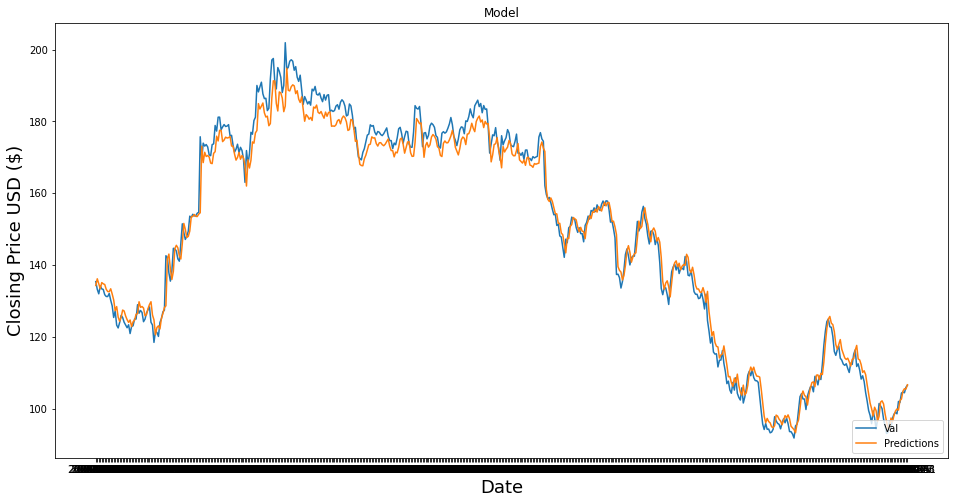

Actual and predicted prices
                 Close  Predictions
Date                               
2020-09-02  135.389999   134.309433
2020-09-03  133.240005   136.176498
2020-09-04  131.990005   134.736511
2020-09-08  134.199997   133.402695
2020-09-09  133.360001   135.118393
...                ...          ...
2022-10-25  104.360001   102.713051
2022-10-26  104.629997   104.894279
2022-10-27  104.440002   105.566513
2022-10-28  105.949997   105.475113
2022-10-31  106.540001   106.667603

[545 rows x 2 columns]
Accuracy : 0.9803012317309497


In [50]:
days = 30
batch_size = 1
epochs = 10

runExperiment(days,training_data_len,batch_size,epochs)

## Experiment 1-2 - Look back 30 days | batch size = 10


x_train shape : (2151, 30, 1)
Training Model :
Epoch 1/10
216/216 [==============================] - 10s 28ms/step - loss: 0.0025
Epoch 2/10
216/216 [==============================] - 6s 28ms/step - loss: 4.5954e-04
Epoch 3/10
216/216 [==============================] - 6s 28ms/step - loss: 3.7499e-04
Epoch 4/10
216/216 [==============================] - 6s 28ms/step - loss: 3.2741e-04
Epoch 5/10
216/216 [==============================] - 6s 28ms/step - loss: 2.9715e-04
Epoch 6/10
216/216 [==============================] - 6s 28ms/step - loss: 2.6582e-04
Epoch 7/10
216/216 [==============================] - 6s 28ms/step - loss: 2.0920e-04
Epoch 8/10
216/216 [==============================] - 6s 28ms/step - loss: 2.0458e-04
Epoch 9/10
216/216 [==============================] - 6s 28ms/step - loss: 2.1680e-04
Epoch 10/10
18/18 [==============================] - 1s 10ms/step
RMSE : 3.856427812453412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


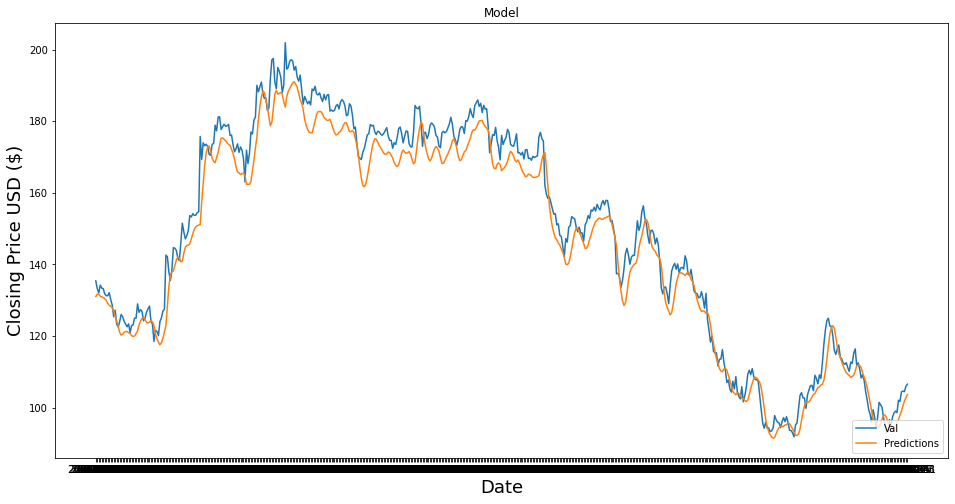

Actual and predicted prices
                 Close  Predictions
Date                               
2020-09-02  135.389999   131.012314
2020-09-03  133.240005   131.700806
2020-09-04  131.990005   131.704895
2020-09-08  134.199997   131.078400
2020-09-09  133.360001   130.915573
...                ...          ...
2022-10-25  104.360001    99.040649
2022-10-26  104.629997   100.500168
2022-10-27  104.440002   101.818672
2022-10-28  105.949997   102.745621
2022-10-31  106.540001   103.632904

[545 rows x 2 columns]
Accuracy : 0.969816346295474


In [51]:
days = 30
batch_size = 10
epochs = 10

runExperiment(days,training_data_len,batch_size,epochs)

## Experiment 2-1 - Look back 60 days | batch size = 1 

x_train shape : (2121, 60, 1)
Training Model :
Epoch 1/10
2121/2121 [==============================] - 64s 29ms/step - loss: 0.0010
Epoch 2/10
2121/2121 [==============================] - 59s 28ms/step - loss: 4.1088e-04
Epoch 3/10
2121/2121 [==============================] - 59s 28ms/step - loss: 2.5280e-04
Epoch 4/10
2121/2121 [==============================] - 59s 28ms/step - loss: 2.2449e-04
Epoch 5/10
2121/2121 [==============================] - 60s 28ms/step - loss: 2.1279e-04
Epoch 6/10
2121/2121 [==============================] - 58s 27ms/step - loss: 2.1426e-04
Epoch 7/10
2121/2121 [==============================] - 59s 28ms/step - loss: 1.7911e-04
Epoch 8/10
2121/2121 [==============================] - 58s 27ms/step - loss: 1.8291e-04
Epoch 9/10
2121/2121 [==============================] - 57s 27ms/step - loss: 1.8031e-04
Epoch 10/10
18/18 [==============================] - 1s 15ms/step
RMSE : 2.1487004676954915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


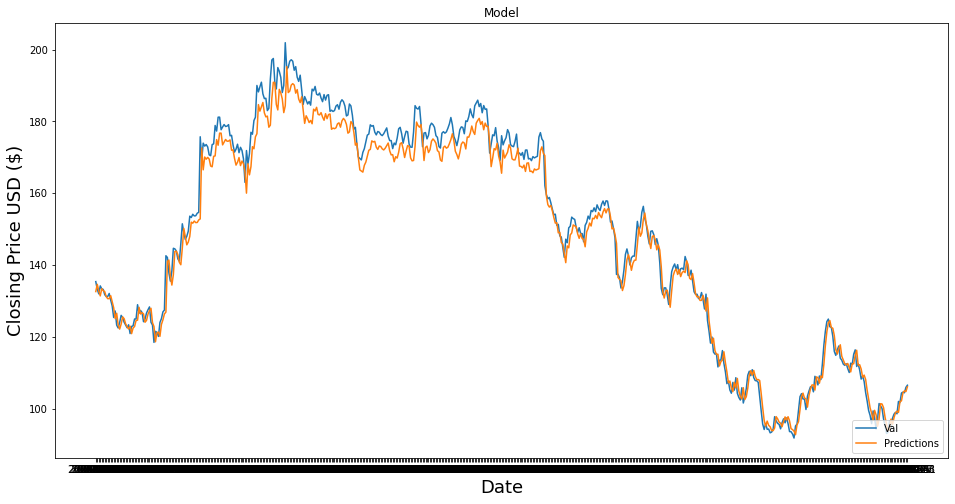

Actual and predicted prices
                 Close  Predictions
Date                               
2020-09-02  135.389999   132.613327
2020-09-03  133.240005   134.642456
2020-09-04  131.990005   132.806625
2020-09-08  134.199997   131.409302
2020-09-09  133.360001   133.421127
...                ...          ...
2022-10-25  104.360001   102.187866
2022-10-26  104.629997   104.421204
2022-10-27  104.440002   104.968849
2022-10-28  105.949997   104.779488
2022-10-31  106.540001   106.112091

[545 rows x 2 columns]
Accuracy : 0.9794008367200725


In [52]:
days = 60
batch_size = 1
epochs = 10

runExperiment(days,training_data_len,batch_size,epochs)

## Experiment 2-2 - Look back 60 days | batch size = 10

x_train shape : (2121, 60, 1)
Training Model :
Epoch 1/10
213/213 [==============================] - 14s 49ms/step - loss: 0.0024
Epoch 2/10
213/213 [==============================] - 10s 48ms/step - loss: 4.2254e-04
Epoch 3/10
213/213 [==============================] - 10s 48ms/step - loss: 4.2118e-04
Epoch 4/10
213/213 [==============================] - 10s 46ms/step - loss: 3.0071e-04
Epoch 5/10
213/213 [==============================] - 11s 50ms/step - loss: 2.4463e-04
Epoch 6/10
213/213 [==============================] - 10s 49ms/step - loss: 2.4581e-04
Epoch 7/10
213/213 [==============================] - 11s 53ms/step - loss: 2.5448e-04
Epoch 8/10
213/213 [==============================] - 12s 57ms/step - loss: 2.1868e-04
Epoch 9/10
213/213 [==============================] - 10s 46ms/step - loss: 1.7867e-04
Epoch 10/10
18/18 [==============================] - 2s 15ms/step
RMSE : 1.0819058773849628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


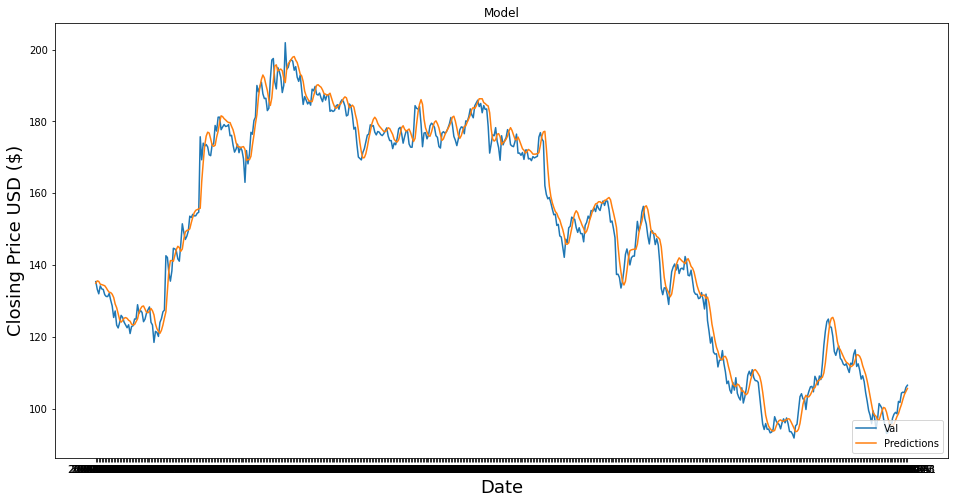

Actual and predicted prices
                 Close  Predictions
Date                               
2020-09-02  135.389999   134.973312
2020-09-03  133.240005   135.592880
2020-09-04  131.990005   135.444580
2020-09-08  134.199997   134.665833
2020-09-09  133.360001   134.558487
...                ...          ...
2022-10-25  104.360001   101.169601
2022-10-26  104.629997   102.663460
2022-10-27  104.440002   103.964302
2022-10-28  105.949997   104.807892
2022-10-31  106.540001   105.649429

[545 rows x 2 columns]
Accuracy : 0.9797341414738638


In [53]:
days = 60
batch_size = 10
epochs = 10

runExperiment(days,training_data_len,batch_size,epochs)

## Experiment 3-1 - Look back 90 days | batch size = 1

x_train shape : (2091, 90, 1)
Training Model :
Epoch 1/10
2091/2091 [==============================] - 82s 38ms/step - loss: 0.0011
Epoch 2/10
2091/2091 [==============================] - 79s 38ms/step - loss: 3.4387e-04
Epoch 3/10
2091/2091 [==============================] - 83s 40ms/step - loss: 2.7080e-04
Epoch 4/10
2091/2091 [==============================] - 81s 39ms/step - loss: 2.1945e-04
Epoch 5/10
2091/2091 [==============================] - 77s 37ms/step - loss: 1.8580e-04
Epoch 6/10
2091/2091 [==============================] - 77s 37ms/step - loss: 1.8366e-04
Epoch 7/10
2091/2091 [==============================] - 80s 38ms/step - loss: 1.9389e-04
Epoch 8/10
2091/2091 [==============================] - 80s 38ms/step - loss: 1.8232e-04
Epoch 9/10
2091/2091 [==============================] - 77s 37ms/step - loss: 1.8393e-04
Epoch 10/10
18/18 [==============================] - 1s 21ms/step
RMSE : 5.3500837147917855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


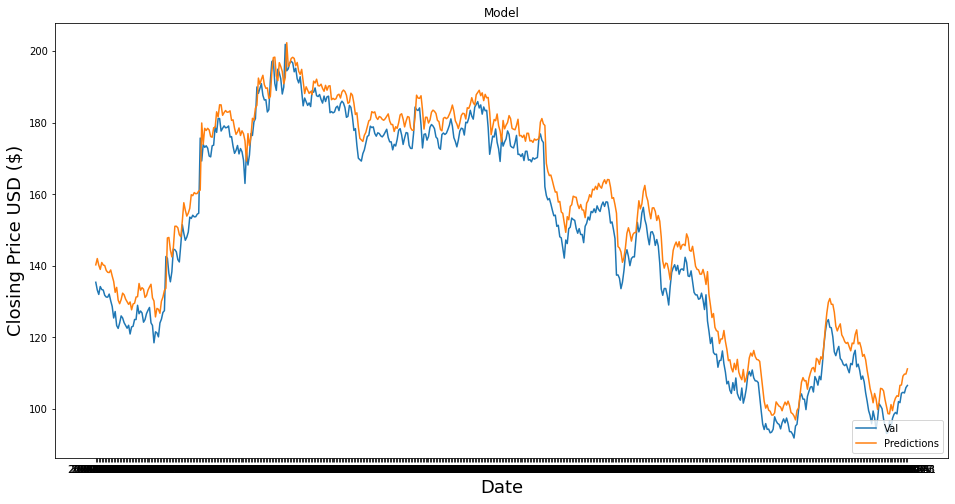

Actual and predicted prices
                 Close  Predictions
Date                               
2020-09-02  135.389999   140.264526
2020-09-03  133.240005   142.022354
2020-09-04  131.990005   140.174255
2020-09-08  134.199997   138.989090
2020-09-09  133.360001   140.922974
...                ...          ...
2022-10-25  104.360001   106.680664
2022-10-26  104.629997   109.143311
2022-10-27  104.440002   109.713760
2022-10-28  105.949997   109.738678
2022-10-31  106.540001   111.174286

[545 rows x 2 columns]
Accuracy : 0.9596682385593515


In [54]:
days = 90
batch_size = 1
epochs = 10

runExperiment(days,training_data_len,batch_size,epochs)

## Experiment 3-2 - Look back 90 days | batch size = 10

x_train shape : (2091, 90, 1)
Training Model :
Epoch 1/10
210/210 [==============================] - 21s 79ms/step - loss: 0.0038
Epoch 2/10
210/210 [==============================] - 15s 72ms/step - loss: 4.4600e-04
Epoch 3/10
210/210 [==============================] - 15s 71ms/step - loss: 4.0913e-04
Epoch 4/10
210/210 [==============================] - 15s 71ms/step - loss: 3.6555e-04
Epoch 5/10
210/210 [==============================] - 15s 71ms/step - loss: 3.3588e-04
Epoch 6/10
210/210 [==============================] - 15s 72ms/step - loss: 2.8751e-04
Epoch 7/10
210/210 [==============================] - 15s 74ms/step - loss: 2.5916e-04
Epoch 8/10
210/210 [==============================] - 16s 76ms/step - loss: 2.3036e-04
Epoch 9/10
210/210 [==============================] - 15s 71ms/step - loss: 2.6559e-04
Epoch 10/10
18/18 [==============================] - 1s 22ms/step
RMSE : 2.639356450107511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


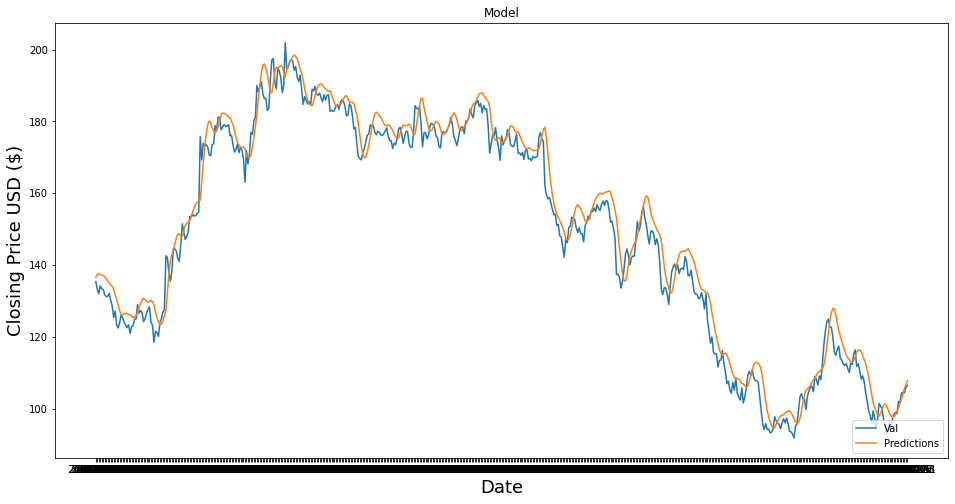

Actual and predicted prices
                 Close  Predictions
Date                               
2020-09-02  135.389999   136.568573
2020-09-03  133.240005   137.397186
2020-09-04  131.990005   137.646286
2020-09-08  134.199997   137.309082
2020-09-09  133.360001   137.225082
...                ...          ...
2022-10-25  104.360001   102.642509
2022-10-26  104.629997   104.174202
2022-10-27  104.440002   105.624786
2022-10-28  105.949997   106.752335
2022-10-31  106.540001   107.811241

[545 rows x 2 columns]
Accuracy : 0.9723120389320173


In [55]:
days = 90
batch_size = 10
epochs = 10

runExperiment(days,training_data_len,batch_size,epochs)